<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> The Overload Distribution Graph Overview </b> </font> </center> <hr>
</div>

<a class="anchor" id="nutshell"></a>



In this notebook you will learn about the Overload Distribution Graph:
    - How to build it ?
    - How to interpret it ?
    - How it could be used to find remedial actions ?

In [1]:
import configparser
import numpy as np
import os
from alphaDeesp.core.grid2op.Grid2opObservationLoader import Grid2opObservationLoader
from alphaDeesp.core.grid2op.Grid2opSimulation import Grid2opSimulation

/home/marotant/dev/ExpertOp4Grid/venv_expert4grid/lib/python3.8/site-packages/grid2op/Backend/pandaPowerBackend.py:32: UserWarning: Numba cannot be loaded. You will gain possibly massive speed if installing it by 
	/home/marotant/dev/ExpertOp4Grid/venv_expert4grid/bin/python -m pip install numba

  warnings.warn(


In [2]:
plot_base_folder="output_plots"#where the plots will be saved

Here is the overall workflow for our Adaptive Expert System algorithm also described in the paper https://hal.science/hal-01897931/file/_LARGE__bf_Expert_System_for_topological_remedial_action_discovery_in_smart_grids.pdf

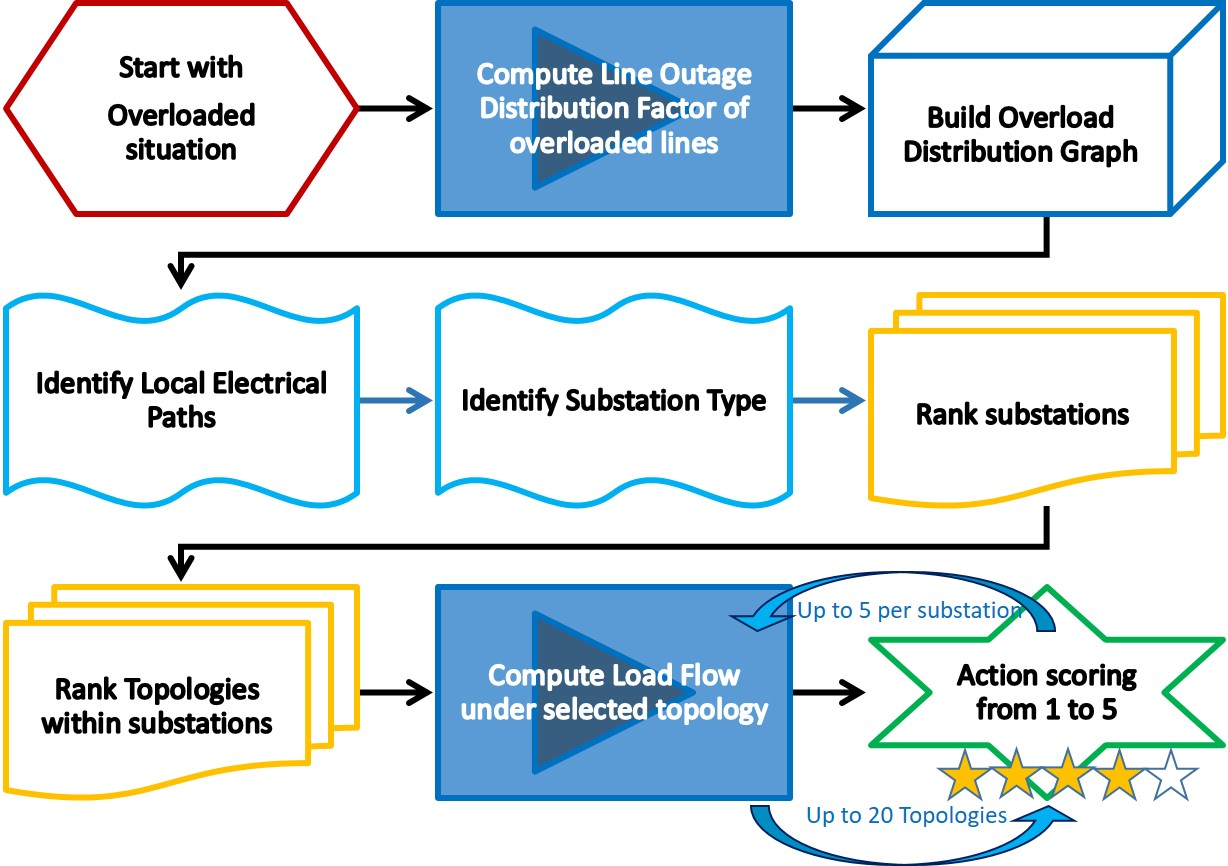

In [3]:
from IPython.display import Image

ExpertOpWorkflow_schematic_file_path="../alphaDeesp/ressources/SchemaSystemeExpert.jpg"
Image(filename=ExpertOpWorkflow_schematic_file_path) 


In this notebook, we will go through the first four steps:
- first creating a raw overload distibution graph 
- then identfying structure in this graph for later ranking

# Setting up grid simulation environment and grid snapshot 

## Grid simulation environment

In [4]:
config = configparser.ConfigParser()
config.read("../alphaDeesp/ressources/config/config.ini")
param_folder = "../alphaDeesp/ressources/parameters/l2rpn_2019/"

chronicscenario=0
timestep=0

loader = Grid2opObservationLoader(param_folder)
env, obs, action_space = loader.get_observation(chronic_scenario= chronicscenario, timestep=timestep)
observation_space = env.observation_space



You might need to install the LightSimBackend (provisory name) to gain massive speed up
INFO - An integer has been provided as chronic scenario - looking for the chronic folder in this position
INFO - the name of the loaded Grid2op scenario is : a


## Check grid state

/tmp/ipykernel_421019/215326481.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


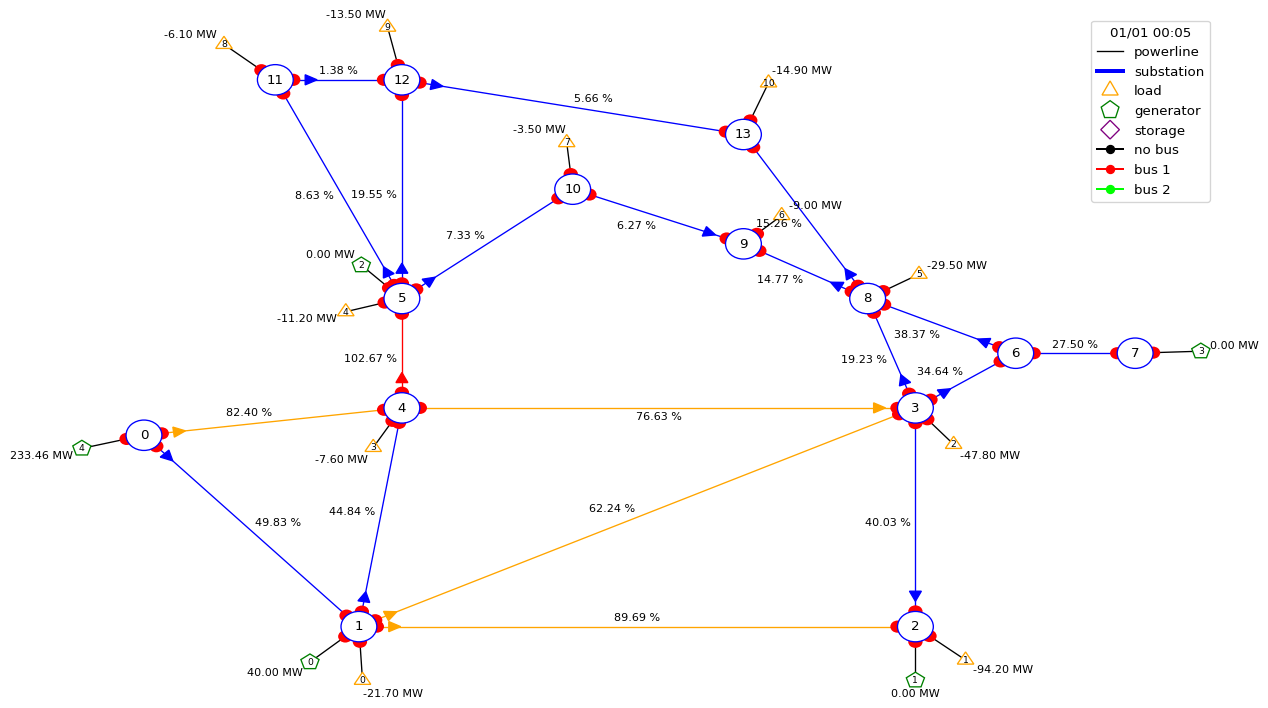

In [5]:
from grid2op.PlotGrid import PlotMatplot

plot_helper = PlotMatplot(env.observation_space)

# if you want to plot all the observation
fig = plot_helper.plot_obs(obs)
fig.show()


We see that line 9 (from substations 4->5) is overloaded

In [6]:
ltc=9
print("line "+str(ltc)+" is overloaded given its loading of "+str(np.round(100*obs.rho[ltc]))+" %")

line 9 is overloaded given its loading of 103.0 %


we want to solve this

# Creating overload distibution graph for overloaded line

## Didactic introduction

To identify where to redispatch the flows to solve this overload, we should find out:
- 1) the main electrical path through which this flow is flowing 
- 2) the parallel paths to which this flow could be redispatched

To identify these paths, we can use the simulation. If we simulate a state in which we prevent the flow from flowing in our overloaded line, this should highlight us:
- paths where the flows get rerouted 
- the main path where the flow is stopped and decreases

To run such an experiment, we artifically disconnect the overloaded line and simulate the resulting state

/tmp/ipykernel_421019/3887096844.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


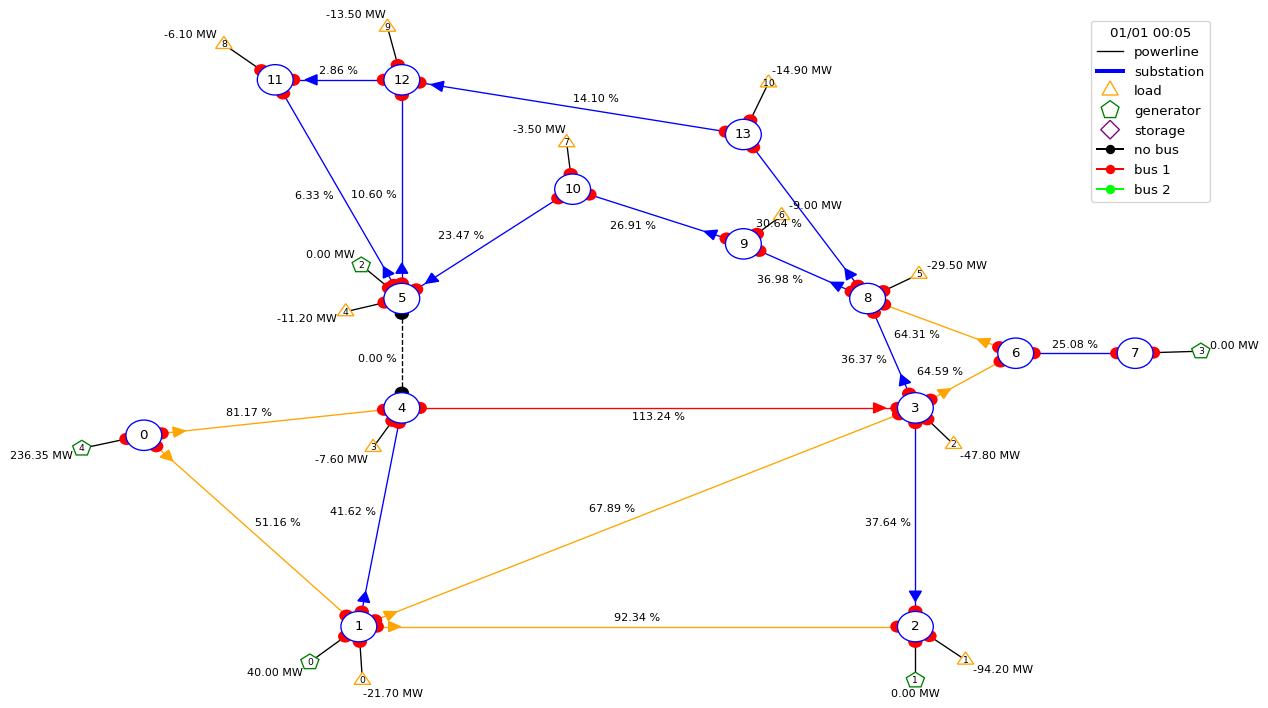

In [7]:
action=env.action_space({"set_line_status": [(ltc, -1)]})
obs_l_disconnected, *_=obs.simulate(action,time_step=0)
fig = plot_helper.plot_obs(obs_l_disconnected)
fig.show()

By comparing before and after disconnection states, we see that flows get redirected through line 4->3 for instance. But to visualize better our path, we will create the overload distribution graphs that display the difference in flows beteween those two states

For this we call the SImulation module of ExpertOp4Grid

## Simulation and Graph computation

In [8]:
from alphaDeesp.main import generate_plot_folders
plot_folder = generate_plot_folders(plot_base_folder, [ltc],chronicscenario,timestep, config)
sim = Grid2opSimulation(obs, action_space, observation_space, param_options=config["DEFAULT"], debug=False,
                                 ltc=[9],plot=True, plot_folder = plot_folder)

self.default output path =  output_plots/l2rpn_2019/linetocut_9/Scenario_0/Timestep_0
Number of generators of the powergrid: 5
Number of loads of the powergrid: 11
Number of powerline of the powergrid: 20
Number of elements connected to each substations in the powergrid: [3 6 4 6 5 6 3 2 5 3 3 3 4 3]
Total number of elements: 56
    idx_or  idx_ex  init_flows  swapped  new_flows  new_flows_swapped  \
0        0       1     157.837    False    161.994              False   
1        0       4      75.622    False     74.356              False   
2        1       2      76.303    False     78.780              False   
3        1       3      55.295    False     60.271              False   
4        1       4      40.187    False     36.657              False   
5        3       2      20.677     True     18.370              False   
6        4       3      63.253     True     98.744              False   
7        3       6      30.408    False     57.576              False   
8        3  

This compute this state difference resulting in this dataframe with flows before and after, and the flow difference

In [9]:
df_of_g = sim.get_dataframe()
df_of_g

,idx_or,idx_ex,init_flows,swapped,new_flows,new_flows_swapped,delta_flows,gray_edges
0,0,1,157.837,False,161.994,False,4.158,True
1,0,4,75.622,False,74.356,False,-1.266,True
2,1,2,76.303,False,78.780,False,2.477,True
3,1,3,55.295,False,60.271,False,4.976,True
4,1,4,40.187,False,36.657,False,-3.531,True
5,3,2,20.677,True,18.370,False,-2.307,True
6,4,3,63.253,True,98.744,False,35.491,False
7,3,6,30.408,False,57.576,False,27.167,False
8,3,8,17.162,False,32.545,False,15.382,False
9,4,5,40.768,False,0.000,False,-40.768,False


one can now compute the overload distribution graph

In [10]:
from alphaDeesp.core.graphsAndPaths import OverFlowGraph
g_over =  OverFlowGraph(sim.topo, [ltc], df_of_g)#sim.build_graph_from_data_frame(ltc)


## Graph visualization and analysis

Let's now visualize this graph

self.default output path =  


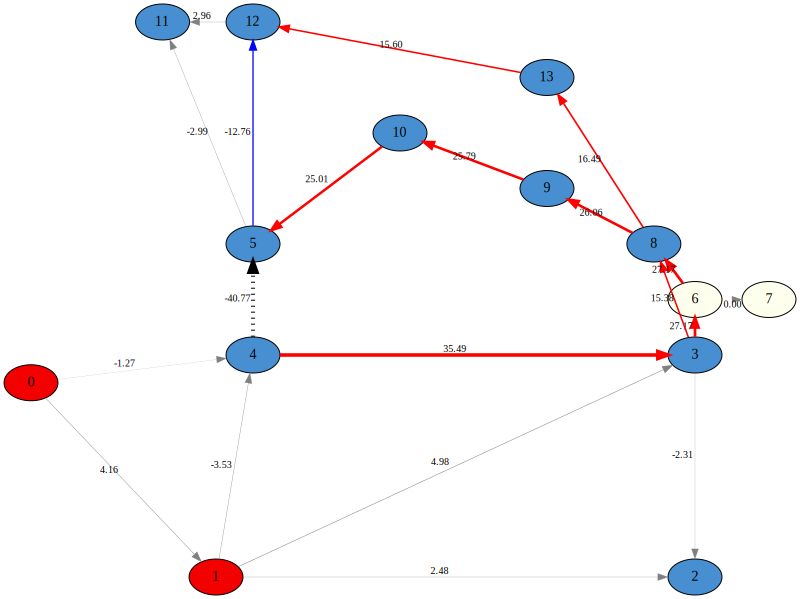

In [11]:
rescale_factor=70#for better layout, you can play with it to change the zoom level
layout_rescale=[(e[0]/rescale_factor,e[1]/rescale_factor) for e in sim.layout]
svg=g_over.plot(layout_rescale,save_folder="")

from IPython.display import SVG, display
SVG(svg)

Or you can draw it in a vertical manner following the flow. You loose the geospatial location but path are more easily identified this way

self.default output path =  


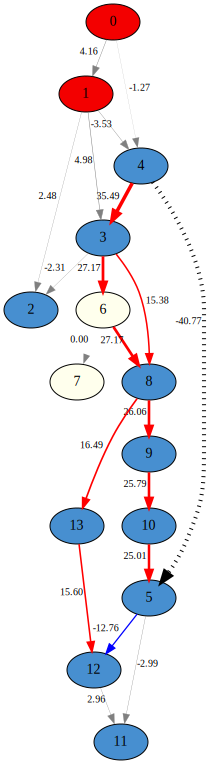

In [12]:
svg=g_over.plot(None,save_folder="")
from IPython.display import SVG, display
SVG(svg)

On this graph we can now clearly see the path we were looking for:
- the main electrical path flowing through the overload is 4 -> 5 -> 6 highlighted in blue
- the parallel path are 4 -> 3 -> 8 -> 9 -> 10 -> 5 and another one continuing to 8 -> 13 ->12 highlighted in red

Other lines are coloured gray meaning the observed flow redispatched is not significant. They can mostly be ignored when aiming at rerouting the flow in our overloaded line 4 -> 5

Here is the resulting graph of significiance

self.default output path =  


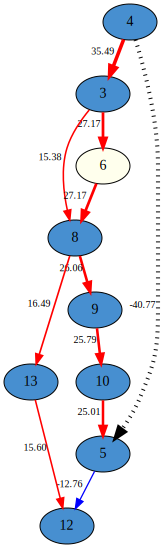

In [13]:
svg=g_over.plot(None,save_folder="",without_gray_edges=True)
from IPython.display import SVG, display
SVG(svg)

The overloaded line is dashed as it got virtually disconnected. But it of course belong to the blue path, called the constrained path, with negative redispatch

Nodes with both blue and red lines are identified as hubs. Those are locations where flow can be most easily rerouted as you want to 
- 

You can also save it as a pdf and reload it

In [16]:
g_over.plot(sim.layout,sim.plot_folder)

plot_folder=os.path.join(sim.plot_folder,"Base graph")
for file in os.listdir(os.path.join(sim.plot_folder,"Base graph")):
    if file.endswith(".pdf"):
        if "g_overflow" in file:
            print("file to visualize is "+file)
            file_path=os.path.join(plot_folder,str(file))
            break
        
from IPython.display import IFrame
IFrame(file_path, width=1000, height=800)

self.default output path =  output_plots/l2rpn_2019/linetocut_9/Scenario_0/Timestep_0
name =  g_overflow_print
============================= FUNCTION create_namefile =============================
hard_filename =  output_plots/l2rpn_2019/linetocut_9/Scenario_0/Timestep_0/Base graph/g_overflow_print_geo_2024-06-25_21-02.pdf
we print the cmd line =  neato -n -Tpdf "output_plots/l2rpn_2019/linetocut_9/Scenario_0/Timestep_0/Base graph/g_overflow_print_geo_2024-06-25_21-02.dot" -o "output_plots/l2rpn_2019/linetocut_9/Scenario_0/Timestep_0/Base graph/g_overflow_print_geo_2024-06-25_21-02.pdf"
file to visualize is g_overflow_print_geo_2024-06-22_16-31.pdf


## Use the Overload Graph

Let's see how we can use it

self.default output path =  


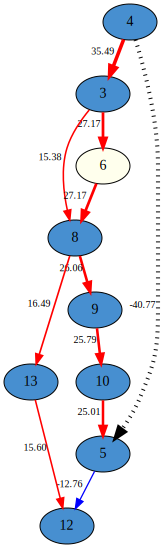

In [15]:
svg=g_over.plot(None,save_folder="",without_gray_edges=True)
from IPython.display import SVG, display
SVG(svg)

Different options are available to redispatch the flows and relieve the overload 4 -> 5:
- Prevent the flow on the blue path by increasing it impedence such as disconnecting 
- limit the consumption on this blue path downstream
- limit the production on this blue path upstream
- increase the production on this blue path downstream

And Conversely on the red paths:
- Allow the flow on the red path by decreasing its impedence such as reconnecting lines or nodes 
- increase the production on this blue path upstream



The most flexible locations are the hubs with both red path and blue path. In the "Expert System" paper this is explained with the following figure. Depending if you are upstream or downstream the overload, you either want to connect loads or productions to the oveload, as well as grey edges to still allow some flow. On the red path you want to connect all red-lines and blues lines that are not the overload, to block the blue path.

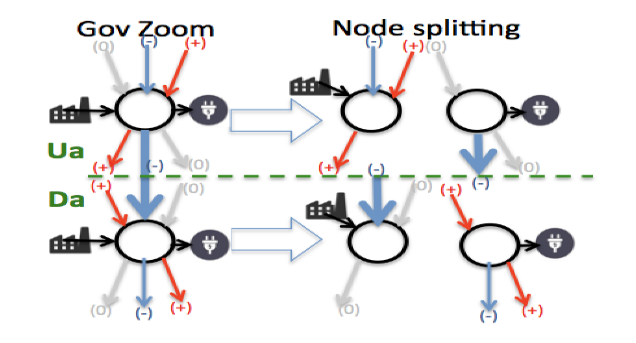

In [17]:
Hubs_explained_file_path="Hubs_redirecting_flows.png"
Image(filename=Hubs_explained_file_path) 

